In [15]:
import math
import itertools
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.ticker import ScalarFormatter

import seaborn as sns

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

from datetime import datetime

SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines',markerfacecolor='w')


def find_nearest(value,df):
    exactmatch = df[df.index==value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbor_ind = df[df.index<value].idxmin()
        upperneighbor_ind = df[df.index>value].idxmax()
    lower_diff = abs(lowerneighbor_ind - value)
    upper_diff = abs(lowerneighbor_ind - value)
    if lower_diff < upper_diff:
        nearest = lowerneighbor_ind
    else:
        nearest = upperneighbor_ind
    return nearest

# Load observed soils data

In [16]:
# load pfas data
pfas = pd.read_excel(r'..\data\PFAS\lf_pfas_summary.xlsx',
                    sheet_name='pfas_nd',na_values='N.D.')
#                      sheet_name='pfas_LnROSrand')
pfas.iloc[:,1:] = pfas.iloc[:,1:]*1000 # convert ng/g to ng/kg

# load soils data
samples = pd.read_excel(r'..\data\lf_data_master.xlsx',sheet_name='main_data')
samples.drop(['clay','silt','sand'], axis=1, inplace=True)
texture = pd.read_excel(r'..\data\lf_particlesizecalc.xlsx',sheet_name='calcs_pivot')
samples = pd.merge(samples,texture, on='sample')

# load TOC data
toc = pd.read_excel(r'..\data\TOC\lf_toc.xlsx',sheet_name='for_python')
toc['foc'] = toc.toc/100

# merge all data
merged = pd.merge(samples, pfas, on='sample')
merged = pd.merge(merged, toc, on='sample')

merged.drop(['depth_ft'], axis=1, inplace=True)
merged.porosity = merged.porosity/100

# take out core A because it didn't receive irrigation
merged.drop(merged[merged['core'] == 'A'].index,inplace=True)
merged.sort_values('depth_m',inplace=True)

water_pfas = pd.read_excel(r'..\data\PFAS\gw_pfas.xlsx',
                        sheet_name='data',
                        na_values='N.D.')
water_pfas = water_pfas[(water_pfas['well'] == 'eff') |
                        (water_pfas['well'] == 'P2') |
                        (water_pfas['well'] == 'P3') |
                        (water_pfas['well'] == 'P5') | 
                        (water_pfas['well'] == 'F3') ]

pd.to_numeric(water_pfas['ng_L'])
water_pfas['kind'] = ['eff' if x == 'eff' else 'gw' for x in water_pfas['well']]
water_stats = water_pfas.groupby(['kind','compound']).describe()
gw_stats = water_stats.loc['gw','ng_L']
eff_stats = water_stats.loc['eff','ng_L']


# Define non-uniform model elements

- Define element sizes by fitting power law to porosity data and integrating.
- find centers of those elements
- calculate the soil mass in each element using power law fit to bulk density data
- fit power law to TOC data and use centers to define the TOC for each element

## define elements

### fit curve to porosity

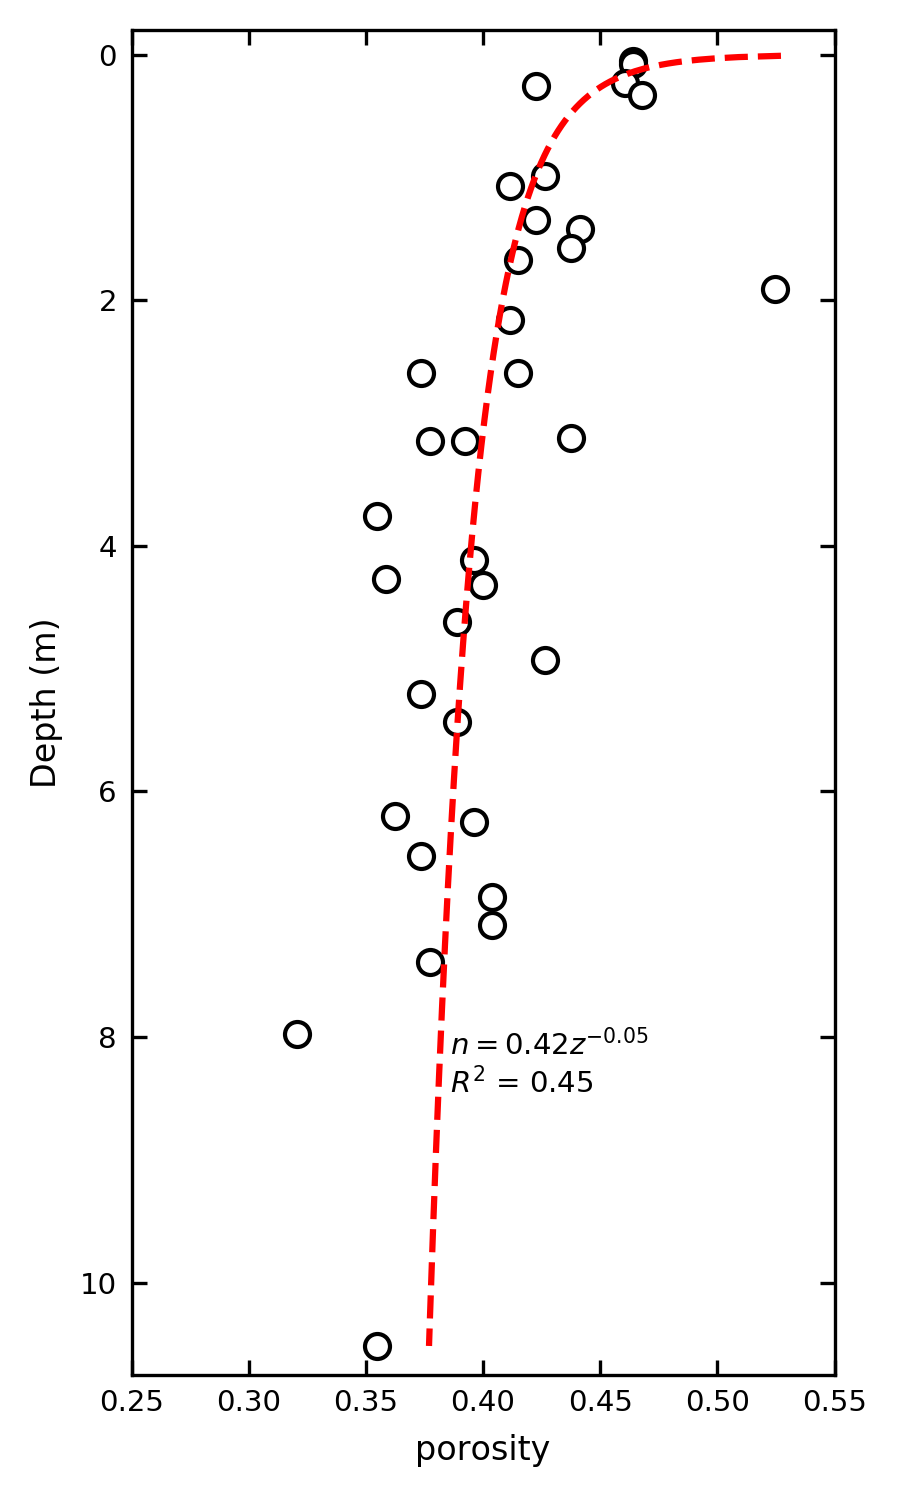

In [17]:
# power law
def f(x, N, a):
    return N * x ** (a)

xData = merged.depth_m.values
yData = merged.porosity.values

# optimize using the appropriate bounds
popt, pcov = curve_fit(f, xData, yData,)
residuals = yData - f(xData, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yData-np.mean(yData))**2)
r_squared = 1 - (ss_res / ss_tot)

xnew = np.linspace(0.01, max(xData), 1000)
N = popt[0]
a = popt[1]
                   
# plot the data
fig,ax = plt.subplots(figsize=(3,5),dpi=300);
ax.plot(yData, xData, 'ko')
ax.plot(f(xnew, *popt), xnew, 'r--')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('porosity')
ax.set_ylim(10.75,-0.2)
ax.tick_params(direction='in',right=True, top=True)
ax.set_xlim(0.25,0.55)
# ax.set_xticks(np.arange(0.3))

# power
ax.annotate('$n = {{{N}}}z^{{{a}}}$\n$R^2$ = {r}'
            .format(N=round(N,2),a=round(a,2),r=round(r_squared,2)),xy=(f(8.5, *popt)+0.005,8.5),va='bottom');

fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig(r'C:\Users\Kalle\Box Sync\Living_filter\figures\por_model.png')

### determine element bounds

In [18]:
# use the integrated function to determine element sizes

A = 1+a
B = N/A
# set depth of first element
d1 = 0.06 # meters
# find volume of first element
V = ((B * d1 ** A) - (B * 0 ** A)) # desired element volume m3

# create depths list
depths = [0]
# add the first element depth
depths.append(d1)

for i in range(2,2000):
    z0 = depths[i-1] # the previous depth
    z1 = ((V/B) + (z0 ** A)) ** (1/A)# the next depth
#     if z1 < 10.6:
    if z1 < 50.1: # decide how deep you want model domain to be
        depths.append(z1)
    else:
        print('last depth = {}, {} elements'.format(round(depths[i-1],4),len(depths)))
        break
# depths = depths+list(np.arange(depths[-1],50,(depths[-1]-depths[-2])))

last depth = 50.032, 604 elements


## determine element centers

In [19]:
# calculate the center of each element
centers = []
focs = []
for i in range(len(depths)-1):
    center = depths[i] + ((depths[i+1] - depths[i])/2)
    centers.append(center)


## Calculate soil masses for elements, fit curve to bulk density

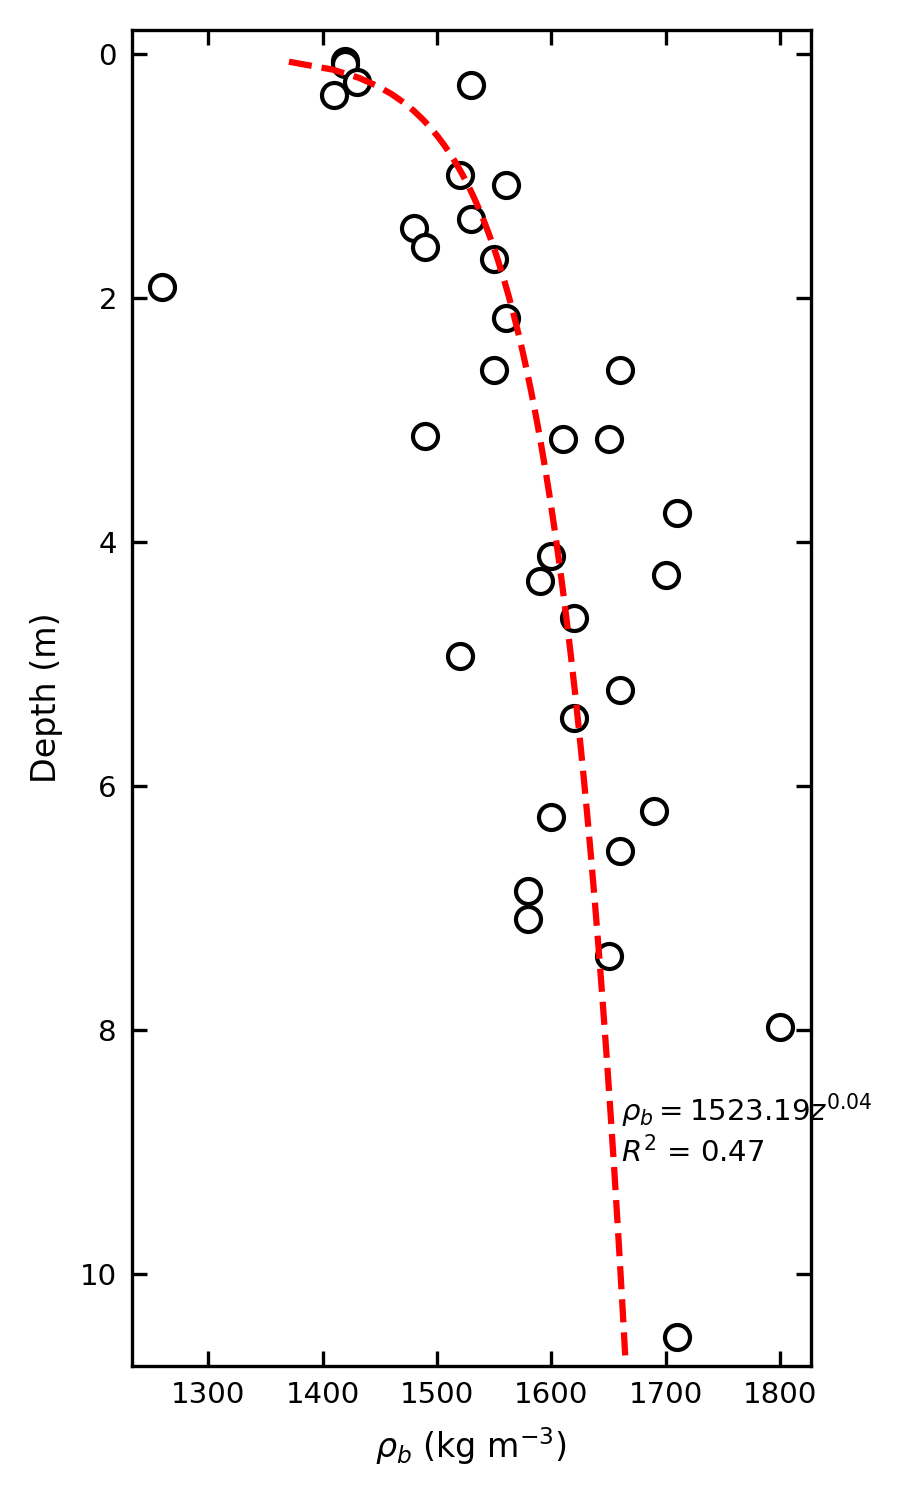

In [20]:
# power law
def f(x, Nm, am):
    return Nm * x ** (am)

# exponential
# def f(x, Nm, am):
#     return Nm * np.exp(am * x)
# linear
# def f(x, Nm, am):
#     return Nm * x + am

xData = merged.depth_m.values
yData = merged.dry_bulk_density.values * 1000 # kg/m3 soil

# optimize using the appropriate bounds
popt, pcov = curve_fit(f, xData, yData)
residuals = yData - f(xData, *popt)
Nm = popt[0]
am = popt[1]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yData-np.mean(yData))**2)
r_squared = 1 - (ss_res / ss_tot)

xnew = np.linspace(0.01, max(xData), 1000)
                   
# plot the data
fig,ax = plt.subplots(figsize=(3,5),dpi=300)
ax.plot(yData, xData, 'ko')
ax.plot(f(depths[1:], *popt), depths[1:], 'r--')

# power
ax.annotate('$ρ_b = {{{Nm}}}z^{{{am}}}$\n$R^2$ = {r}'
            .format(Nm=round(Nm,2),am=round(am,2),r=round(r_squared,2)),
            xy=(f(8.5, *popt)+10,8.5),va='top');

ax.set_ylim(10.75,-0.2)
ax.set_xlabel('$ρ_b$ (kg m$^{-3}$)')
ax.set_ylabel('Depth (m)')
ax.tick_params(direction='in',right=True, top=True)
# exponential
# ax.annotate('$\rho = {{{Nm}}}z+{{{a}}}$\n$R^2$ = {r}'.format(Nm=Nm,a=a,r=round(r_squared,2)),
#                xy=(8,f(8, *popt)),va='bottom');
# linear
# ax.annotate('$n = {{{Nm}}}z+{{{a}}}$\n$R^2$ = {r}'.format(Nm=Nm,a=a,r=round(r_squared,2)),
#                xy=(8,f(8, *popt)),va='bottom');


# CALCULATE MASSES USING INTERGRATION
Am = 1+am
Bm = Nm/Am

soil_masses = []

# find masses of the elements
for i in range(0,len(depths)-1):
    z0 = depths[i]
    z1 = depths[i+1]
#     Mnew = 
    M = ((Bm * z1 ** Am) - (Bm * z0 ** Am)) # mass from the integration
    soil_masses.append(M)

fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig(r'C:\Users\Kalle\Box Sync\Living_filter\figures\bulk_model.png')

## Calculate element foc values using centers and power law fit to foc data

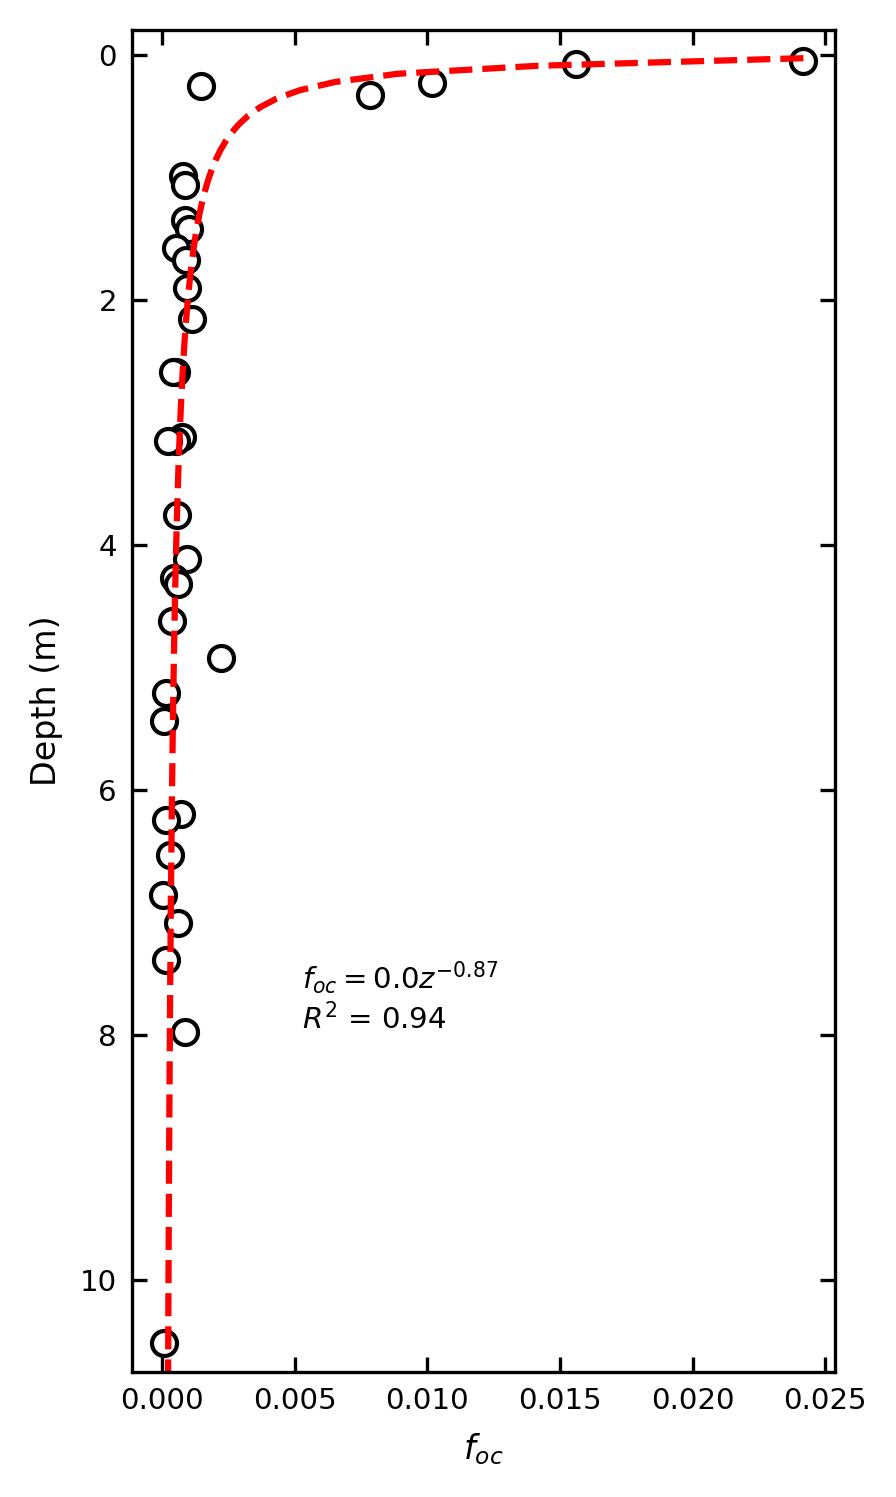

In [21]:
# power law
def f(x, N, a):
    return N * x ** (a)

xData = merged.depth_m.values
yData = merged.foc.values

# optimize using the appropriate bounds
popt, pcov = curve_fit(f, xData, yData)
residuals = yData - f(xData, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((yData-np.mean(yData))**2)
r_squared = 1 - (ss_res / ss_tot)

xnew = np.linspace(0.01, max(xData), 1000)
N = popt[0]
a = popt[1]
                   
# plot the data
fig, ax = plt.subplots(figsize=(3,5),dpi=300)

ax.plot(yData,xData, 'ko')
# ax.plot(f(depths[1:], *popt), depths[1:], 'r--')
ax.set_ylim(10.75,-0.2)

# assign each element an Foc value
focs = f(centers, *popt)
# swap out the first fit value with an actual value to eliminate the high tail
# that sticks out beyond what has been observed to 5% TOC or so
focs[0] = merged.foc.values[0]
focs0 = focs.copy()
# setting focs lower below a certain depth, meant to represent shift to sbedrock...
depth = 30
idx = np.searchsorted(centers, depth, side="left")
focs0[idx:] = 0
ax.plot(focs,centers,'--',color='r')

# power
ax.annotate('$f_{{oc}}= {{{N}}}z^{{{a}}}$\n$R^2$ = {r}'
            .format(N=round(N,2),a=round(a,2),r=round(r_squared,2)),
            xy=(f(8, *popt)+0.005,8),va='bottom');
ax.set_xlabel('$f_{oc}$')
ax.set_ylabel('Depth (m)')
ax.tick_params(direction='in',right=True, top=True)
fig.tight_layout()
fig.patch.set_facecolor('w')
# fig.savefig(r'C:\Users\Kalle\Box Sync\Living_filter\figures\foc_model.png')

# Define PFAA mass flux bucket model

## original version

In [23]:
def bucket(sol_mass_in, kd, soil_masses,pfas):
    # matrices for storing the previous step
    sol_old = np.zeros(len(centers)) # solution mass (ng)
    ads_old = np.zeros(len(centers)) # adsorbed (ng)
    # tot_old = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    # matrices for storing the new step
    sol_new = np.zeros(len(centers)) # solution mass (ng)
    ads_new = np.zeros(len(centers)) # adsorbed (ng)
    # tot_new = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    sol_df = pd.DataFrame(index=centers)
    ads_df = pd.DataFrame(index=centers)

    # set up the first element 
    sol_old[0] = sol_mass_in[0]
    tot = sol_old[0] + ads_old[0] # calculate total mass for equilibration
    kd_temp = kd[0] * (soil_masses[0]/(V*1000)) # unitless for use with masses
    ads_old[0] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
    sol_old[0] = tot - ads_old[0] # assigning the solute portion

    for j in range(len(sol_mass_in)):
    # For each step, add new mass to the first element of sol_new
        sol_new[0] = sol_mass_in[j]
    # then move all the solution masses down one element
        sol_new[1:] = sol_old[:-1].copy()
        out = sol_old[-1:].copy()
    # then go through each element to calculate new ads and sol matrices...
        for i in range(len(centers)):
            tot = sol_new[i] + ads_old[i] # need to calculate equilibration
            kd_temp = kd[i] * (soil_masses[i]/(V*1000)) # unitless for use with masses
            ads_new[i] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
            sol_new[i] = tot - ads_new[i] # assigning the solute portion
        # calculate concentrations from the masses
#         print('sol_new contains only floats: ', np.isfinite(sol_new).all())
        sol_df[j+1] = sol_new / (V*1000) # ng/m3
        ads_df[j+1] = ads_new / soil_masses # ng/Kg
        
#         if np.array_equal(ads_new.round(2), ads_old.round(2)):
#             break # stop the simulation if the arrays have not changed 
#         else:
#             # reset the matrices to go again
        sol_old = sol_new.copy()
        ads_old = ads_new.copy()

    ads_df_ngg = ads_df / 1000 # convert from ng/kg to ng/g

    sol_df_ngL = sol_df / 1000 # convert from ng/m3 to ng/L

    # calculate RMSE for 2014
    mod = ads_df.iloc[:,50*52] # 1964 to 2014 = 50 years
    obs = merged.set_index('depth_m').loc[:,pfas].dropna()
    obs.sort_index(inplace=True)
    # model and observed depths don't match
    # so need to find closest matches...
    shared = []
    for i in obs.index:
        shared.append(find_nearest(i,mod))

    modeled = mod[shared].values
    observed = obs.values
    weights = [10 if x < 2. else 1 for x in shared]
    # RMSE
    rmse = np.sqrt(mean_squared_error(observed, modeled,
                                      sample_weight=weights
                                     )
                  )
    return ads_df, sol_df, rmse

## version with faster timestep

In [24]:
def bucket_day(sol_mass_in, kd, soil_masses, pfas):
    # matrices for storing the previous step
    sol_old = np.zeros(len(centers)) # solution mass (ng)
    ads_old = np.zeros(len(centers)) # adsorbed (ng)
    # tot_old = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    # matrices for storing the new step
    sol_new = np.zeros(len(centers)) # solution mass (ng)
    ads_new = np.zeros(len(centers)) # adsorbed (ng)
    # tot_new = np.zeros(len(centers)) # book-keeping matrix for calculating equlibrium

    sol_df = pd.DataFrame(index=centers)
    ads_df = pd.DataFrame(index=centers)

    # set up the first element 
    sol_old[0] = sol_mass_in[0]
    tot = sol_old[0] + ads_old[0] # calculate total mass for equilibration
    kd_temp = kd[0] * (soil_masses[0]/(V*1000)) # unitless for use with masses
    ads_old[0] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
    sol_old[0] = tot - ads_old[0] # assigning the solute portion

    for j in range(len(sol_mass_in)):
    # For each step, add new mass to the first element of sol_new
        sol_new[0] = sol_mass_in[j]
    # then move all the solution masses down one element
        sol_new[1:] = sol_old[:-1].copy()
        out = sol_old[-1:].copy()
    # then go through each element to calculate new ads and sol matrices...
        for i in range(len(centers)):
            # check to see if the solution has pfas in it
            if sol_new[i] != False:
            # if it does, do equlibration.
                tot = sol_new[i] + ads_old[i] # need to calculate equilibration
                kd_temp = kd[i] * (soil_masses[i]/(V*1000)) # unitless for use with masses
                ads_new[i] = tot * (kd_temp/(kd_temp+1)) # assigning the adsorbed portion
                sol_new[i] = tot - ads_new[i] # assigning the solute portion
        # calculate concentrations from the masses
#         print(sol_new[1])
        sol_df[j+1] = sol_new / (V*1000) # ng/L
        ads_df[j+1] = ads_new / soil_masses # ng/Kg
        
        sol_old = sol_new.copy()
        ads_old = ads_new.copy()

#     # calculate RMSE
#     mod = ads_df.iloc[:,-1]
#     obs = merged.set_index('depth_m').loc[:,pfas].dropna()
#     obs.sort_index(inplace=True)
#     # model and observed depths don't match
#     # so need to find closest matchest...
#     shared = []
#     for i in obs.index:
#         shared.append(find_nearest(i,mod))

#     modeled = mod[shared].values
#     observed = obs.values
#     weights = [10 if x < 1. else 1 for x in shared]
#     # RMSE
#     rmse = np.sqrt(mean_squared_error(observed, modeled))
    return ads_df, sol_df #rmse

# PFOS

## Run parameter sweep

In [251]:
pfaa = 'PFOS'
con_mean = eff_stats.loc[pfaa,'mean']

logkoc_range = [x for x in np.arange(2.4,3.9,.05)]
con_range = list(np.arange(10.,510.,10.))
# 0 in pairs is logkoc and 1 is input concentration
pairs = list(itertools.product(logkoc_range, con_range))
keys = ['{:.2f}_{:.0f}'.format(p[0],p[1]) for p in pairs]

bot_dict = {}
thi_dict = {}
rms_list = []

for p, k in zip(pairs,keys):
    koc = 10**p[0]
    kd = focs * koc

    sol_mass_in = [p[1] * V * 1000]*37*52\ # initial concentration
                + list(np.linspace(p[1] * V * 1000,con_mean * V * 1000,14*52))\ # Linear decrease from 2000-2014
                + [con_mean * V * 1000]*49*52 # 2020 effluent concentration
    ads, sol, rms = bucket(sol_mass_in,kd,soil_masses,pfaa)
    
    thi_dict[k] = sol.iloc[370,:].values
    bot_dict[k] = sol.iloc[-1,:].values
    
    # save pared down versions of the output
    ads.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfos_sweep/ads/'+k+'.csv')
    sol.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfos_sweep/sol/'+k+'.csv')
    
    rms_list.append([k,p[0],p[1],rms])
    
    print(k, datetime.now())

bottom_df = pd.DataFrame(bot_dict)
bottom_df.to_csv('./pfos_sweep/bottom.csv')
thirty_df = pd.DataFrame(thi_dict)
thirty_df.to_csv('./pfos_sweep/thirty.csv')

rms_df = pd.DataFrame(rms_list,columns = ['key','logKoc','con_in','rms'])
rms_df.to_csv('./pfos_sweep/rms.csv')

del bottom_df, thirty_df, rms_df, bot_dict, thi_dict, rms_list

2.40_10 2021-04-18 08:28:12.566416
2.40_20 2021-04-18 08:28:22.622931
2.40_30 2021-04-18 08:28:32.569692
2.40_40 2021-04-18 08:28:42.573059
2.40_50 2021-04-18 08:28:52.535507
2.40_60 2021-04-18 08:29:02.501330
2.40_70 2021-04-18 08:29:12.438920
2.40_80 2021-04-18 08:29:22.344859
2.40_90 2021-04-18 08:29:32.395270
2.40_100 2021-04-18 08:29:42.367018
2.40_110 2021-04-18 08:29:52.251349
2.40_120 2021-04-18 08:30:02.246630
2.40_130 2021-04-18 08:30:12.166597
2.40_140 2021-04-18 08:30:22.076785
2.40_150 2021-04-18 08:30:32.036644
2.40_160 2021-04-18 08:30:41.946083
2.40_170 2021-04-18 08:30:51.822430
2.40_180 2021-04-18 08:31:01.788221
2.40_190 2021-04-18 08:31:11.783298
2.40_200 2021-04-18 08:31:21.758171
2.40_210 2021-04-18 08:31:31.668934
2.40_220 2021-04-18 08:31:41.598133
2.40_230 2021-04-18 08:31:51.531289
2.40_240 2021-04-18 08:32:01.475467
2.40_250 2021-04-18 08:32:11.583447
2.40_260 2021-04-18 08:32:21.661934
2.40_270 2021-04-18 08:32:31.523168
2.40_280 2021-04-18 08:32:41.448924
2

2.60_300 2021-04-18 09:29:27.157671
2.60_310 2021-04-18 09:29:37.366992
2.60_320 2021-04-18 09:29:47.464417
2.60_330 2021-04-18 09:29:57.582730
2.60_340 2021-04-18 09:30:07.707135
2.60_350 2021-04-18 09:30:17.668416
2.60_360 2021-04-18 09:30:27.625943
2.60_370 2021-04-18 09:30:37.624855
2.60_380 2021-04-18 09:30:47.634238
2.60_390 2021-04-18 09:30:57.641144
2.60_400 2021-04-18 09:31:07.597978
2.60_410 2021-04-18 09:31:17.624552
2.60_420 2021-04-18 09:31:27.563393
2.60_430 2021-04-18 09:31:37.550323
2.60_440 2021-04-18 09:31:47.520007
2.60_450 2021-04-18 09:31:57.539571
2.60_460 2021-04-18 09:32:07.573564
2.60_470 2021-04-18 09:32:17.574417
2.60_480 2021-04-18 09:32:27.568557
2.60_490 2021-04-18 09:32:37.567962
2.60_500 2021-04-18 09:32:47.474879
2.65_10 2021-04-18 09:32:57.634854
2.65_20 2021-04-18 09:33:07.764091
2.65_30 2021-04-18 09:33:17.821624
2.65_40 2021-04-18 09:33:27.763305
2.65_50 2021-04-18 09:33:37.755287
2.65_60 2021-04-18 09:33:47.740739
2.65_70 2021-04-18 09:33:57.728189

2.85_90 2021-04-18 10:07:50.133988
2.85_100 2021-04-18 10:08:00.088220
2.85_110 2021-04-18 10:08:10.082474
2.85_120 2021-04-18 10:08:20.154432
2.85_130 2021-04-18 10:08:30.187551
2.85_140 2021-04-18 10:08:40.149999
2.85_150 2021-04-18 10:08:50.212883
2.85_160 2021-04-18 10:09:00.279671
2.85_170 2021-04-18 10:09:10.387436
2.85_180 2021-04-18 10:09:20.441328
2.85_190 2021-04-18 10:09:30.621546
2.85_200 2021-04-18 10:09:40.743932
2.85_210 2021-04-18 10:09:50.791012
2.85_220 2021-04-18 10:10:00.813911
2.85_230 2021-04-18 10:10:10.841783
2.85_240 2021-04-18 10:10:20.927009
2.85_250 2021-04-18 10:10:31.052072
2.85_260 2021-04-18 10:10:41.039245
2.85_270 2021-04-18 10:10:51.296524
2.85_280 2021-04-18 10:11:01.358981
2.85_290 2021-04-18 10:11:11.354142
2.85_300 2021-04-18 10:11:21.518623
2.85_310 2021-04-18 10:11:31.612616
2.85_320 2021-04-18 10:11:41.745148
2.85_330 2021-04-18 10:11:51.849205
2.85_340 2021-04-18 10:12:01.833764
2.85_350 2021-04-18 10:12:11.914788
2.85_360 2021-04-18 10:12:22.

3.05_380 2021-04-18 10:46:33.766432
3.05_390 2021-04-18 10:46:43.963796
3.05_400 2021-04-18 10:46:54.086289
3.05_410 2021-04-18 10:47:04.218668
3.05_420 2021-04-18 10:47:14.550321
3.05_430 2021-04-18 10:47:24.631855
3.05_440 2021-04-18 10:47:34.723690
3.05_450 2021-04-18 10:47:44.891727
3.05_460 2021-04-18 10:47:54.993657
3.05_470 2021-04-18 10:48:05.152955
3.05_480 2021-04-18 10:48:15.431313
3.05_490 2021-04-18 10:48:25.722680
3.05_500 2021-04-18 10:48:35.862681
3.10_10 2021-04-18 10:48:46.037235
3.10_20 2021-04-18 10:48:56.101195
3.10_30 2021-04-18 10:49:06.240663
3.10_40 2021-04-18 10:49:16.568947
3.10_50 2021-04-18 10:49:26.687670
3.10_60 2021-04-18 10:49:37.116070
3.10_70 2021-04-18 10:49:47.300395
3.10_80 2021-04-18 10:49:57.659814
3.10_90 2021-04-18 10:50:09.439228
3.10_100 2021-04-18 10:50:20.482681
3.10_110 2021-04-18 10:50:30.814184
3.10_120 2021-04-18 10:50:40.934763
3.10_130 2021-04-18 10:50:51.055356
3.10_140 2021-04-18 10:51:01.217266
3.10_150 2021-04-18 10:51:11.462644
3

3.30_170 2021-04-18 11:25:47.453094
3.30_180 2021-04-18 11:25:57.663365
3.30_190 2021-04-18 11:26:07.966393
3.30_200 2021-04-18 11:26:18.172494
3.30_210 2021-04-18 11:26:28.423486
3.30_220 2021-04-18 11:26:38.646920
3.30_230 2021-04-18 11:26:48.806237
3.30_240 2021-04-18 11:26:59.031987
3.30_250 2021-04-18 11:27:09.302923
3.30_260 2021-04-18 11:27:19.616983
3.30_270 2021-04-18 11:27:29.885437
3.30_280 2021-04-18 11:27:40.237456
3.30_290 2021-04-18 11:27:50.503061
3.30_300 2021-04-18 11:28:00.798613
3.30_310 2021-04-18 11:28:11.100875
3.30_320 2021-04-18 11:28:21.363120
3.30_330 2021-04-18 11:28:31.637507
3.30_340 2021-04-18 11:28:41.968233
3.30_350 2021-04-18 11:28:52.210250
3.30_360 2021-04-18 11:29:02.567577
3.30_370 2021-04-18 11:29:15.705158
3.30_380 2021-04-18 11:29:25.858573
3.30_390 2021-04-18 11:29:36.069606
3.30_400 2021-04-18 11:29:46.398147
3.30_410 2021-04-18 11:29:56.527949
3.30_420 2021-04-18 11:30:06.704231
3.30_430 2021-04-18 11:30:16.865010
3.30_440 2021-04-18 11:30:27

3.50_460 2021-04-18 12:05:12.991386
3.50_470 2021-04-18 12:05:23.295758
3.50_480 2021-04-18 12:05:33.666885
3.50_490 2021-04-18 12:05:44.239297
3.50_500 2021-04-18 12:05:54.551842
3.55_10 2021-04-18 12:06:05.998618
3.55_20 2021-04-18 12:06:17.747969
3.55_30 2021-04-18 12:06:28.058361
3.55_40 2021-04-18 12:06:38.348627
3.55_50 2021-04-18 12:06:48.644968
3.55_60 2021-04-18 12:06:58.933689
3.55_70 2021-04-18 12:07:09.180953
3.55_80 2021-04-18 12:07:19.598488
3.55_90 2021-04-18 12:07:30.025427
3.55_100 2021-04-18 12:07:40.364522
3.55_110 2021-04-18 12:07:50.772232
3.55_120 2021-04-18 12:08:01.158219
3.55_130 2021-04-18 12:08:11.494923
3.55_140 2021-04-18 12:08:21.804773
3.55_150 2021-04-18 12:08:32.088033
3.55_160 2021-04-18 12:08:42.439581
3.55_170 2021-04-18 12:08:52.764602
3.55_180 2021-04-18 12:09:03.133815
3.55_190 2021-04-18 12:09:13.388984
3.55_200 2021-04-18 12:09:23.649487
3.55_210 2021-04-18 12:09:33.931234
3.55_220 2021-04-18 12:09:44.158320
3.55_230 2021-04-18 12:09:54.636409
3

3.75_250 2021-04-18 12:44:54.702393
3.75_260 2021-04-18 12:45:05.046275
3.75_270 2021-04-18 12:45:15.436543
3.75_280 2021-04-18 12:45:25.799920
3.75_290 2021-04-18 12:45:36.148538
3.75_300 2021-04-18 12:45:46.526669
3.75_310 2021-04-18 12:45:56.835076
3.75_320 2021-04-18 12:46:07.266961
3.75_330 2021-04-18 12:46:17.582587
3.75_340 2021-04-18 12:46:27.914527
3.75_350 2021-04-18 12:46:38.270298
3.75_360 2021-04-18 12:46:48.676281
3.75_370 2021-04-18 12:46:59.068409
3.75_380 2021-04-18 12:47:09.363481
3.75_390 2021-04-18 12:47:19.771568
3.75_400 2021-04-18 12:47:30.220853
3.75_410 2021-04-18 12:47:40.499654
3.75_420 2021-04-18 12:47:50.812582
3.75_430 2021-04-18 12:48:01.209602
3.75_440 2021-04-18 12:48:11.502060
3.75_450 2021-04-18 12:48:21.818351
3.75_460 2021-04-18 12:48:32.176602
3.75_470 2021-04-18 12:48:42.536754
3.75_480 2021-04-18 12:48:52.913276
3.75_490 2021-04-18 12:49:03.261935
3.75_500 2021-04-18 12:49:13.520239
3.80_10 2021-04-18 12:49:23.931014
3.80_20 2021-04-18 12:49:34.3

## Retrieve data from csv files if sweep has been run in past

In [4]:
ads_dict5s = {}
sol_dict5s = {}

for csv in os.listdir('./pfos_sweep/ads'):
    key = os.path.splitext(csv)[0]
    a = pd.read_csv('./pfos_sweep/ads/'+csv,index_col='Unnamed: 0')
    a.columns = [int(x) for x in a.columns.values]
    s = pd.read_csv('./pfos_sweep/sol/'+csv,index_col='Unnamed: 0')
    s.columns = [int(x) for x in s.columns.values]
    ads_dict5s[key] = a
    sol_dict5s[key] = s
    
bottom_df = pd.read_csv('./pfos_sweep/bottom.csv')
thirty_df = pd.read_csv('./pfos_sweep/thirty.csv')
rms_df = pd.read_csv('./pfos_sweep/rms.csv')
rms_df.sort_values('key',inplace=True)
rms_df.set_index('key',inplace=True)

## Heatmap

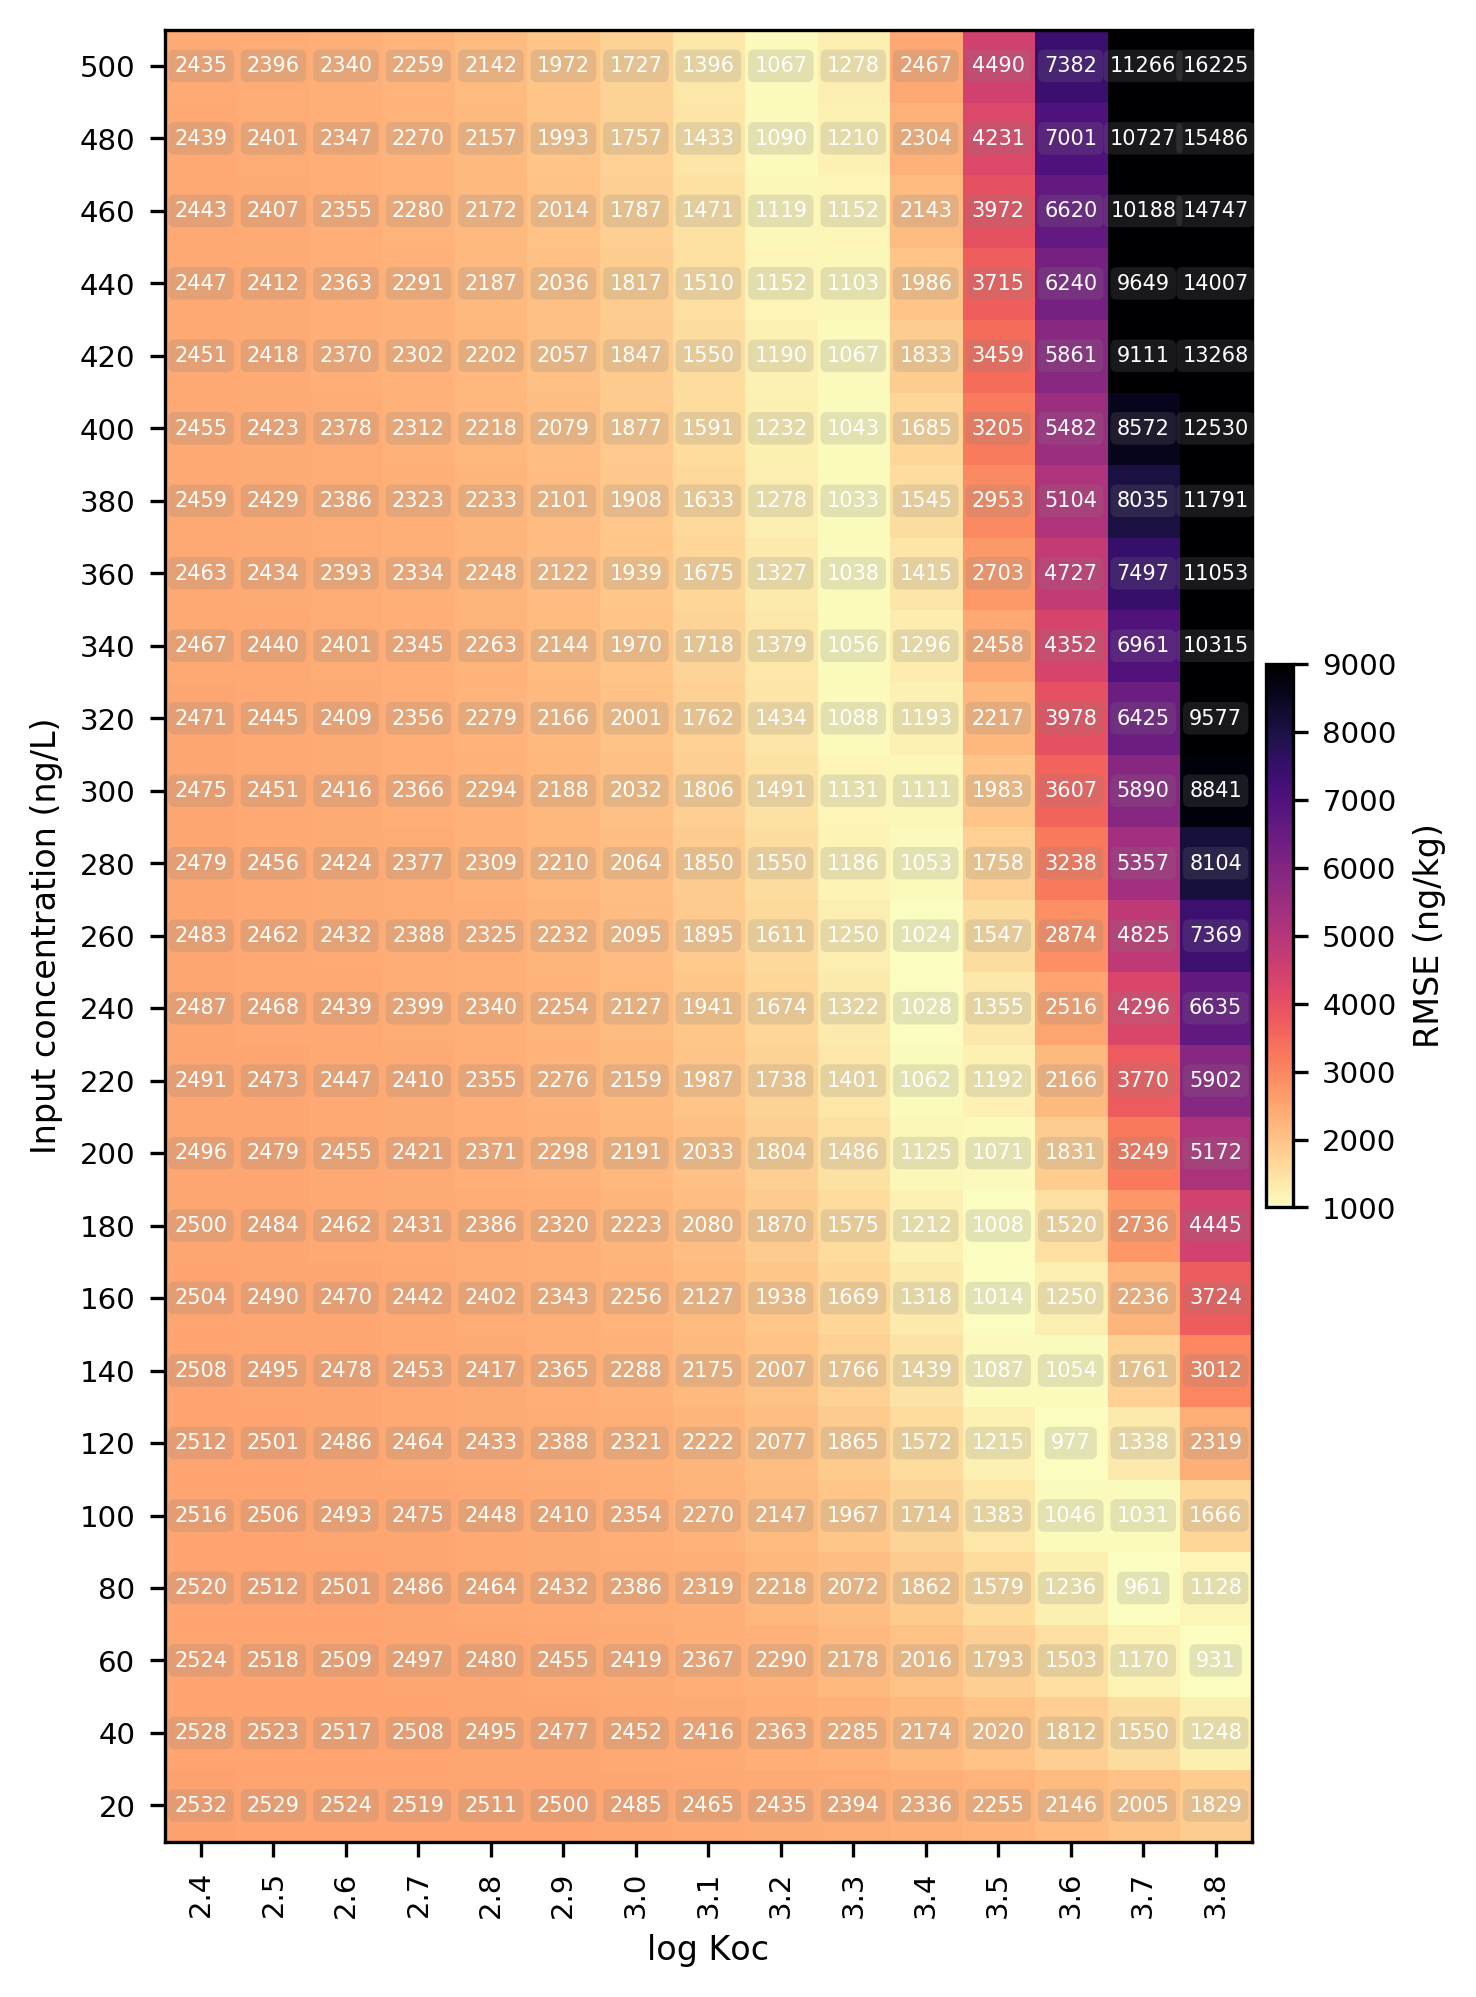

In [355]:
rms_piv = rms_df.pivot(columns='logKoc',index='con_in',values='rms')
rms_piv.columns = rms_piv.columns.values.round(2)
display_cons = np.arange(20.,510.,20.)
display_koc = np.arange(2.4,3.85,.1).round(2)
rms_piv = rms_piv.loc[display_cons,display_koc]

fig, ax = plt.subplots(figsize=(6,8),dpi=300)
im = ax.imshow((rms_piv.values),cmap='magma_r',aspect='equal',
               vmin=1000,vmax=9000
              )

ax.set_xticks(np.arange(len(rms_piv.columns)))
ax.set_yticks(np.arange(len(rms_piv.index)))

ax.set_xticklabels(rms_piv.columns.values.round(2),rotation=90)
ax.set_yticklabels(int(x) for x in rms_piv.index.values)
ax.set_ylabel('Input concentration (ng/L)')
ax.set_xlabel('log Koc')
ax.invert_yaxis()

cb = fig.colorbar(im,ax=ax,shrink=0.3,pad=0.01,label='RMSE (ng/kg)')

bbox = dict(boxstyle="round", fc="gray",lw='0',alpha=.2)
for i,k in enumerate(rms_piv.index):
    for j,c in enumerate(rms_piv.columns):
        if np.isnan(rms_piv.loc[k, c]) == False:
            ax.annotate('{:.0f}'.format(rms_piv.loc[k, c]), (j, i),fontsize=5, 
                           ha='center', va='center', color='w',bbox=bbox)
fig.patch.set_facecolor('w')

## Time Series

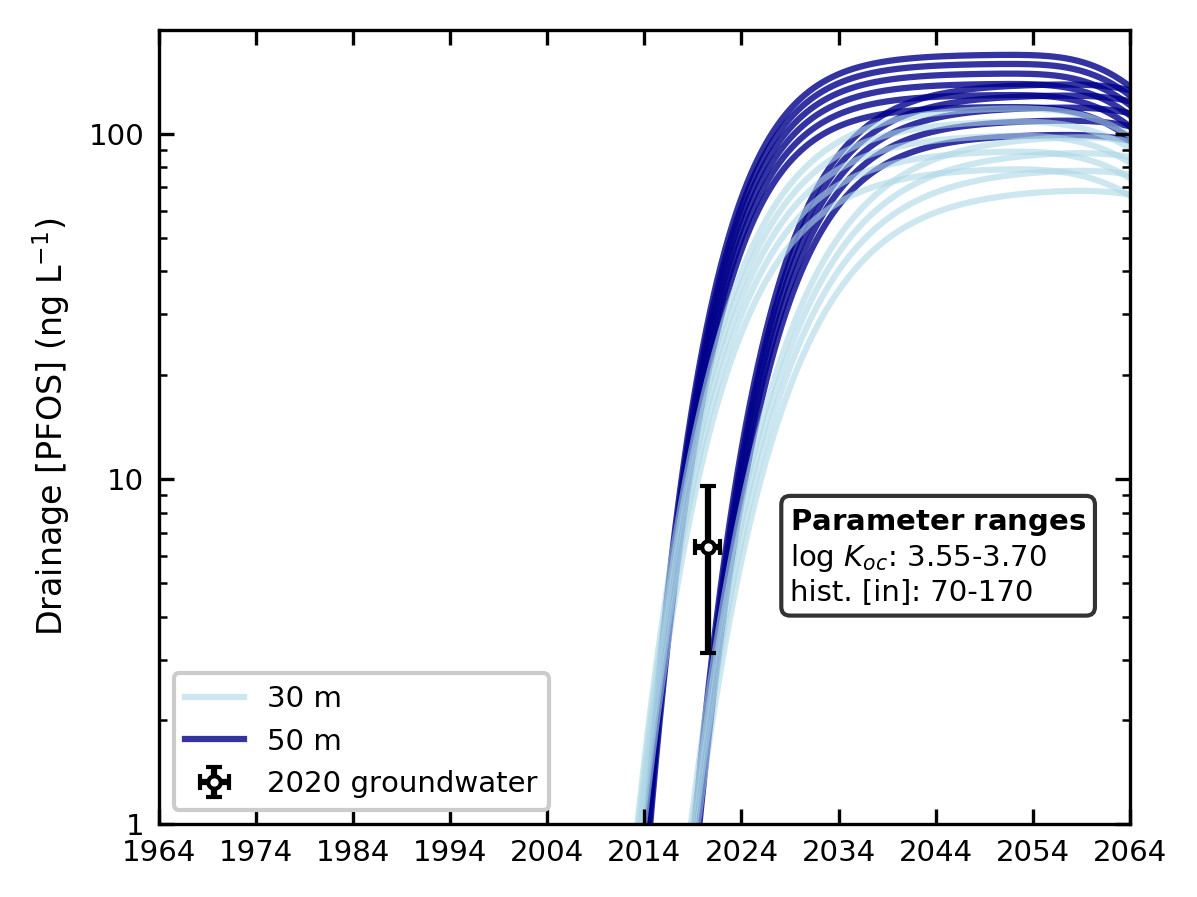

In [12]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,5201,1.)

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

#------------------------------------------------
# linear drop between 2000-2014
# plot best rms results
best_keys_30 = rms_df[
                    ((rms_df['logKoc'].round(2) == 3.65)|
                     (rms_df['logKoc'].round(2) == 3.7)) &
                    (rms_df['rms'] < 1100)].index.values
best_keys_50 = rms_df[
                    ((rms_df['logKoc'].round(2) == 3.55)|
                     (rms_df['logKoc'].round(2) == 3.6)) &
                    (rms_df['rms'] < 1100)
                    ].index.values


for i,key in enumerate(best_keys_30):
    thirty = thirty_df[key]
    if i == 0:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1, label='30 m')
    else:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1)
        
for i,key in enumerate(best_keys_50):
    bottom = bottom_df[key]
    if i == 0:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1, label='50 m')
    else:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1)

# manually make the label
key = best_keys_30[-1]
thirty = thirty_df[key]
vals = key.split('_')
second = best_keys_30[0].split('_')
ax.annotate('$\mathbf{{Parameter}}$ $\mathbf{{ranges}}$\nlog $K_{oc}$: 3.55-3.70\nhist. [in]: 70-170',xycoords='axes fraction',
            xy=(.65,.4),bbox=bbox,va='top',ha='left')

#------------------------------------------------
# make pretty
ax.set_xlim(0,100*52)
ax.set_xticks([x*52 for x in np.arange(0,110,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2074,10)]);

ax.errorbar([56.5*52],[gw_stats.loc['PFOS','mean']],
            yerr=[gw_stats.loc['PFOS','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)



ax.set_ylabel('Drainage [PFOS] (ng L$^{-1}$)')
ax.set_yscale('log')
ax.set_ylim(1,200)
ax.yaxis.set_major_formatter(ScalarFormatter())

ax.tick_params(which='both',direction='in',right=True,top=True)
ax.legend(loc='lower left',framealpha=1)
fig.tight_layout()
fig.savefig('./figs/pfos_time_series_final.png')

## Profile

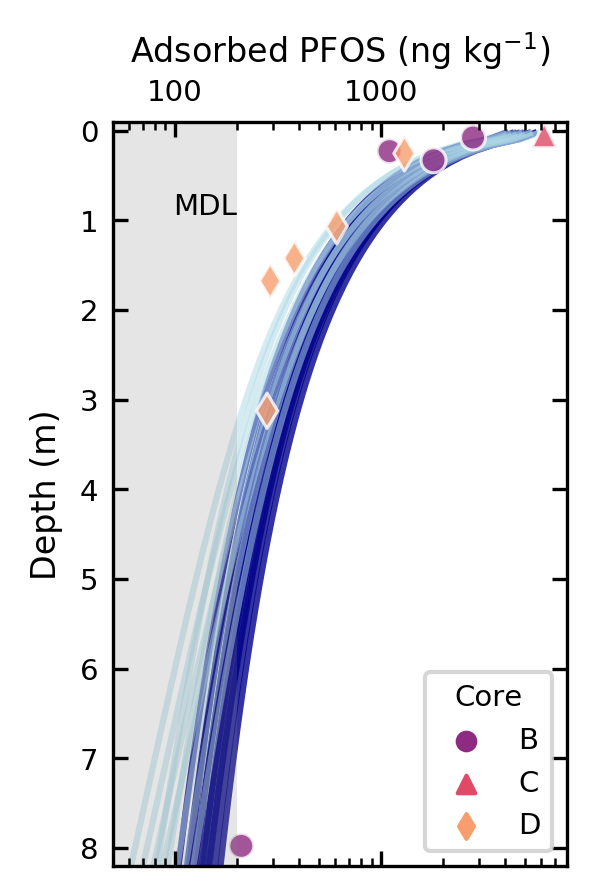

In [7]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOS',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D2A81','#DF4A69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)

low = .1
high = .9
number_of_lines= 1
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap('viridis_r')
colors = [ cmap(x) for x in cm_subsection ]

    
for key in best_keys_30_5s:
    ax.plot(ads_dict5s[key].loc[:,2601].values,ads_dict5s[key].loc[:,2601].index.values,'-',c='lightblue',alpha=.5,
           zorder=-1)
    
for key in best_keys_50_5s:
    ax.plot(ads_dict5s[key].loc[:,2601].values,ads_dict5s[key].loc[:,2601].index.values,'-',c='darkblue',alpha=.8,
           zorder=-2)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='lower right',markerscale=.7, title='Core')


ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOS (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')

ax.annotate('', xy=(.95,.7), xycoords='axes fraction', fontsize=12,ha='right');

ax.set_xscale('log')
ax.set_xlim(50,8000)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(8.2,-.1)

ax.axvspan(10,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(.2*1000,1),va='bottom',ha='right')
fig.tight_layout()
fig.savefig('./figs/pfos_profile_final.png')

# PFOA

## Run parameter sweep

In [250]:
pfaa = 'PFOA'
con_mean = eff_stats.loc[pfaa,'mean']

logkoc_range = list(np.arange(1.9,2.8,.1))
con_range = list(np.arange(10.,510.,10.))+list(np.arange(600.,3100.,100.))
# 0 in pairs is logkoc and 1 is input concentration
pairs = list(itertools.product(logkoc_range, con_range))
keys = ['{:.1f}_{:.0f}'.format(p[0],p[1]) for p in pairs]

bot_dict = {}
thi_dict = {}
rms_list = []

for p, k in zip(pairs,keys):
    koc = 10**p[0]
    kd = focs * koc
#     sol_mass_in = [p[1] * V * 1000 for x in range(41*52)]+[con_mean * V * 1000 for x in range(59*52)]
    sol_mass_in = [p[1] * V * 1000]*37*52\
                + list(np.linspace(p[1] * V * 1000,con_mean * V * 1000,14*52))\
                + [con_mean * V * 1000]*49*52
    ads, sol, rms = bucket(sol_mass_in,kd,soil_masses,pfaa)
    
    thi_dict[k] = sol.iloc[370,:].values
    bot_dict[k] = sol.iloc[-1,:].values
    
#     ads_dict[k] = ads
#     sol_dict[k] = sol
    # save pared down versions of the output
    ads.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfoa_sweep/ads5/'+k+'.csv')
    sol.iloc[:,[10*52,20*52,50*52,56*52,75*52,-1]].to_csv('./pfoa_sweep/sol5/'+k+'.csv')
    
    rms_list.append([k,p[0],p[1],rms])
    
    print(k, datetime.now())
    
bottom_df = pd.DataFrame(bot_dict)
bottom_df.to_csv('./pfoa_sweep/bottom_v5.csv')
thirty_df = pd.DataFrame(thi_dict)
thirty_df.to_csv('./pfoa_sweep/thirty_v5.csv')

rms_df = pd.DataFrame(rms_list,columns = ['key','logKoc','con_in','rms'])
rms_df.to_csv('./pfoa_sweep/rms_v5.csv')

del bottom_df, thirty_df, rms_df, bot_dict, thi_dict, rms_list

1.9_10 2021-04-17 22:20:17.508955
1.9_20 2021-04-17 22:20:27.456461
1.9_30 2021-04-17 22:20:37.412684
1.9_40 2021-04-17 22:20:47.377407
1.9_50 2021-04-17 22:20:57.399879
1.9_60 2021-04-17 22:21:07.557969
1.9_70 2021-04-17 22:21:17.605856
1.9_80 2021-04-17 22:21:27.670503
1.9_90 2021-04-17 22:21:37.586231
1.9_100 2021-04-17 22:21:47.703023
1.9_110 2021-04-17 22:21:57.750479
1.9_120 2021-04-17 22:22:07.675034
1.9_130 2021-04-17 22:22:17.637632
1.9_140 2021-04-17 22:22:27.564342
1.9_150 2021-04-17 22:22:37.494683
1.9_160 2021-04-17 22:22:47.468679
1.9_170 2021-04-17 22:22:57.508073
1.9_180 2021-04-17 22:23:07.506593
1.9_190 2021-04-17 22:23:17.545003
1.9_200 2021-04-17 22:23:27.508833
1.9_210 2021-04-17 22:23:37.384579
1.9_220 2021-04-17 22:23:47.377999
1.9_230 2021-04-17 22:23:57.253580
1.9_240 2021-04-17 22:24:07.220030
1.9_250 2021-04-17 22:24:17.166298
1.9_260 2021-04-17 22:24:27.159111
1.9_270 2021-04-17 22:24:37.153194
1.9_280 2021-04-17 22:24:47.278678
1.9_290 2021-04-17 22:24:57.2

2.2_100 2021-04-17 22:59:11.014766
2.2_110 2021-04-17 22:59:20.936186
2.2_120 2021-04-17 22:59:30.894483
2.2_130 2021-04-17 22:59:40.894908
2.2_140 2021-04-17 22:59:50.903607
2.2_150 2021-04-17 23:00:00.831155
2.2_160 2021-04-17 23:00:10.737406
2.2_170 2021-04-17 23:00:20.765480
2.2_180 2021-04-17 23:00:30.685789
2.2_190 2021-04-17 23:00:40.809762
2.2_200 2021-04-17 23:00:50.758431
2.2_210 2021-04-18 07:13:59.034652
2.2_220 2021-04-18 07:14:10.059229
2.2_230 2021-04-18 07:14:21.000414
2.2_240 2021-04-18 07:14:31.204407
2.2_250 2021-04-18 07:14:41.477810
2.2_260 2021-04-18 07:14:51.542541
2.2_270 2021-04-18 07:15:01.542809
2.2_280 2021-04-18 07:15:11.517425
2.2_290 2021-04-18 07:15:21.300992
2.2_300 2021-04-18 07:15:31.361659
2.2_310 2021-04-18 07:15:41.526622
2.2_320 2021-04-18 07:15:51.861041
2.2_330 2021-04-18 07:16:01.802220
2.2_340 2021-04-18 07:16:11.713498
2.2_350 2021-04-18 07:16:21.561211
2.2_360 2021-04-18 07:16:31.513186
2.2_370 2021-04-18 07:16:41.291918
2.2_380 2021-04-18 0

2.5_190 2021-04-18 07:51:05.428170
2.5_200 2021-04-18 07:51:15.594259
2.5_210 2021-04-18 07:51:25.604810
2.5_220 2021-04-18 07:51:35.579695
2.5_230 2021-04-18 07:51:45.628939
2.5_240 2021-04-18 07:51:55.668197
2.5_250 2021-04-18 07:52:05.789830
2.5_260 2021-04-18 07:52:15.727974
2.5_270 2021-04-18 07:52:25.950437
2.5_280 2021-04-18 07:52:36.009226
2.5_290 2021-04-18 07:52:46.065066
2.5_300 2021-04-18 07:52:55.939104
2.5_310 2021-04-18 07:53:05.884464
2.5_320 2021-04-18 07:53:15.860957
2.5_330 2021-04-18 07:53:25.843788
2.5_340 2021-04-18 07:53:36.397061
2.5_350 2021-04-18 07:53:46.530964
2.5_360 2021-04-18 07:53:56.576081
2.5_370 2021-04-18 07:54:06.804056
2.5_380 2021-04-18 07:54:16.729617
2.5_390 2021-04-18 07:54:26.734576
2.5_400 2021-04-18 07:54:36.733341
2.5_410 2021-04-18 07:54:46.994157
2.5_420 2021-04-18 07:54:57.277661
2.5_430 2021-04-18 07:55:07.642411
2.5_440 2021-04-18 07:55:17.667206
2.5_450 2021-04-18 07:55:27.643788
2.5_460 2021-04-18 07:55:37.665909
2.5_470 2021-04-18 0

## Retrieve data from csv files if sweep has been run in the past

In [8]:
ads_dict = {}
sol_dict = {}

for csv in os.listdir('./pfoa_sweep/ads5'):
    key = os.path.splitext(csv)[0]
    a = pd.read_csv('./pfoa_sweep/ads5/'+csv,index_col='Unnamed: 0')
    a.columns = [int(x) for x in a.columns.values]
    s = pd.read_csv('./pfoa_sweep/sol5/'+csv,index_col='Unnamed: 0')
    s.columns = [int(x) for x in s.columns.values]
    ads_dict[key] = a
    sol_dict[key] = s

bottom_df = pd.read_csv('./pfoa_sweep/bottom_v5.csv')
thirty_df = pd.read_csv('./pfoa_sweep/thirty_v5.csv')
rms_df = pd.read_csv('./pfoa_sweep/rms_v5.csv')
rms_drop = rms_df.copy()
rms_drop.sort_values(by=['logKoc','con_in'],inplace=True)
rms_drop.set_index('key',inplace=True)

## heatmap

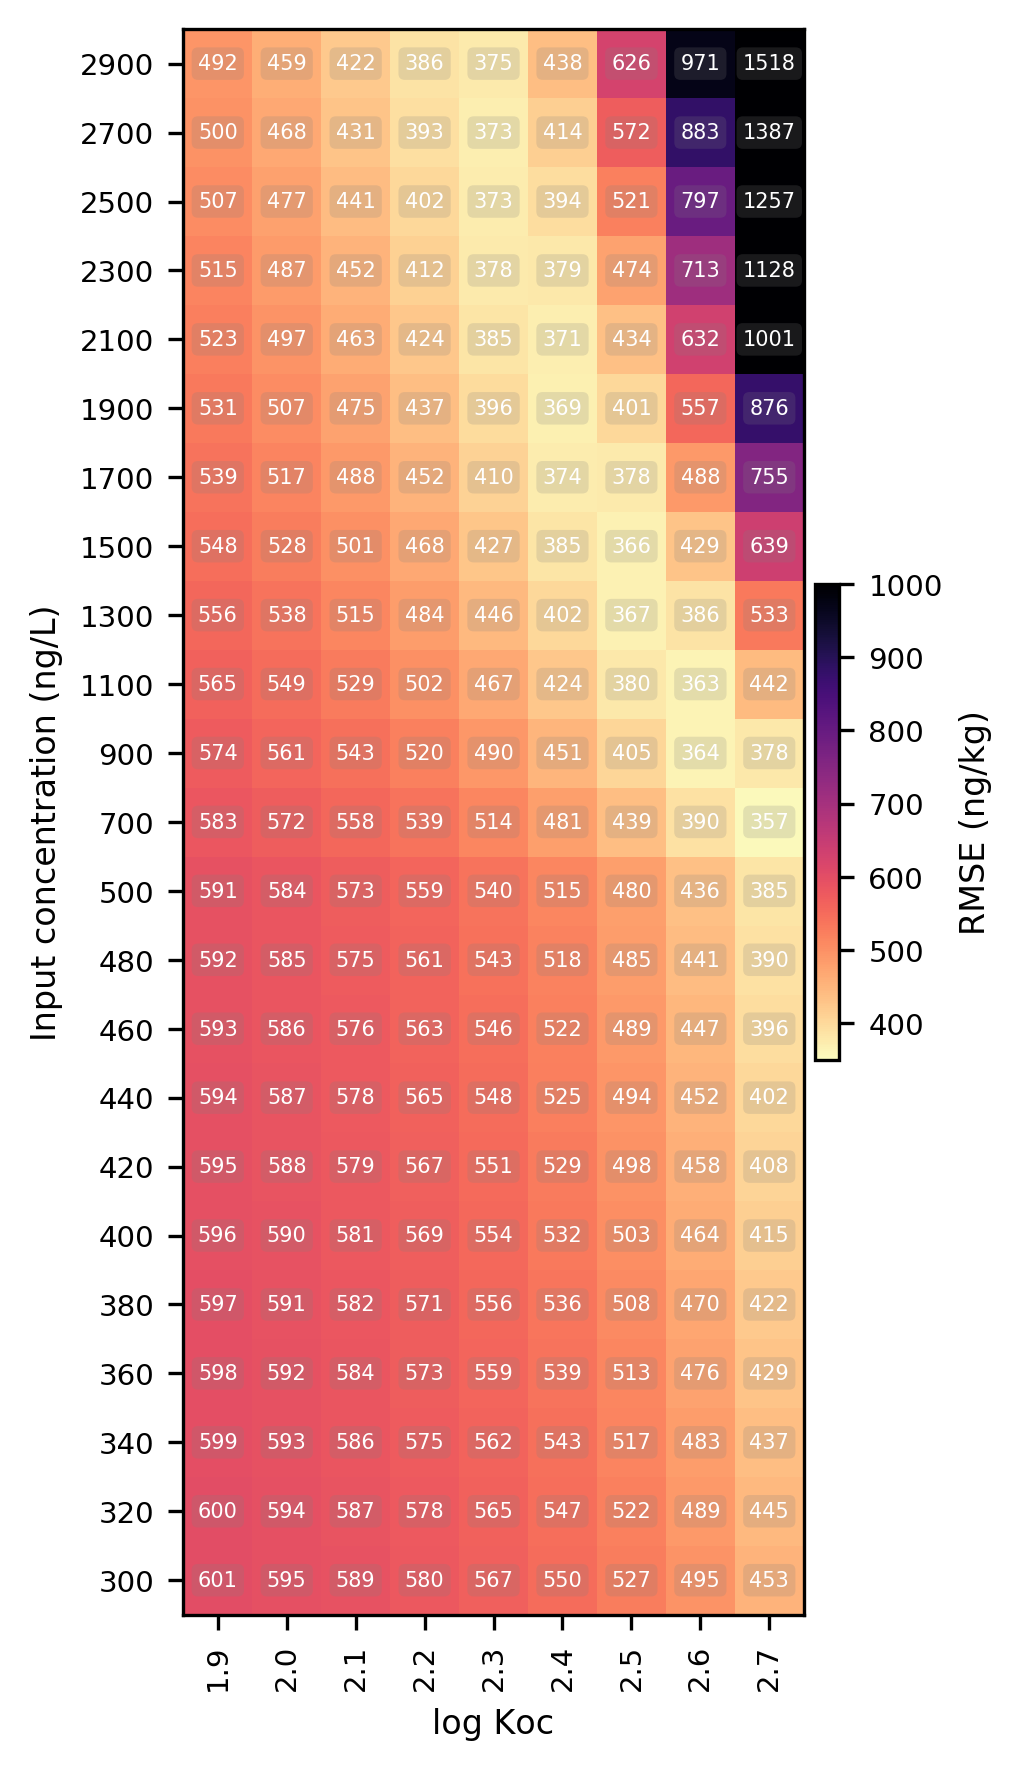

In [354]:
rms_piv = rms_drop.pivot(columns='logKoc',index='con_in',values='rms')
# display_cons = np.arange(20.,10.,20.)
display_logkoc = np.arange(1.9,2.8,.1)
rms_piv = rms_piv.iloc[range(29,len(rms_piv),2),:]
# df = rms_piv.loc[]

fig, ax = plt.subplots(figsize=(5,7),dpi=300)
im = ax.imshow((rms_piv.values),cmap='magma_r',aspect='equal',
               vmin=350,vmax=1000
#                norm=colors.LogNorm()
              )

ax.set_xticks(np.arange(len(rms_piv.columns)))
ax.set_yticks(np.arange(len(rms_piv.index)))

# ax.set_xticklabels(int(x) for x in rms_piv.columns.values)
# ax.set_yticklabels(rms_piv.index.values.round(1))
ax.set_xticklabels(rms_piv.columns.values.round(2),rotation=90)
ax.set_yticklabels(int(x) for x in rms_piv.index.values)
ax.set_ylabel('Input concentration (ng/L)')
ax.set_xlabel('log Koc')
ax.invert_yaxis()

cb = fig.colorbar(im,ax=ax,shrink=0.3,pad=0.01,label='RMSE (ng/kg)')
# cb.ax.get_yaxis().set_ticklabels(np.arange(1.5,5,.5))
# cb.ax.set_title('x1000',ha='left',fontsize=6)
# cb.ax.xaxis.set_major_formatter(ScalarFormatter())

bbox = dict(boxstyle="round", fc="gray",lw='0',alpha=.2)
for i,k in enumerate(rms_piv.index):
    for j,c in enumerate(rms_piv.columns):
        if np.isnan(rms_piv.loc[k, c]) == False:
            ax.annotate('{:.0f}'.format(rms_piv.loc[k, c]), (j, i),fontsize=5, 
                           ha='center', va='center', color='w',bbox=bbox)
# fig.tight_layout()
fig.patch.set_facecolor('w')

## Time series

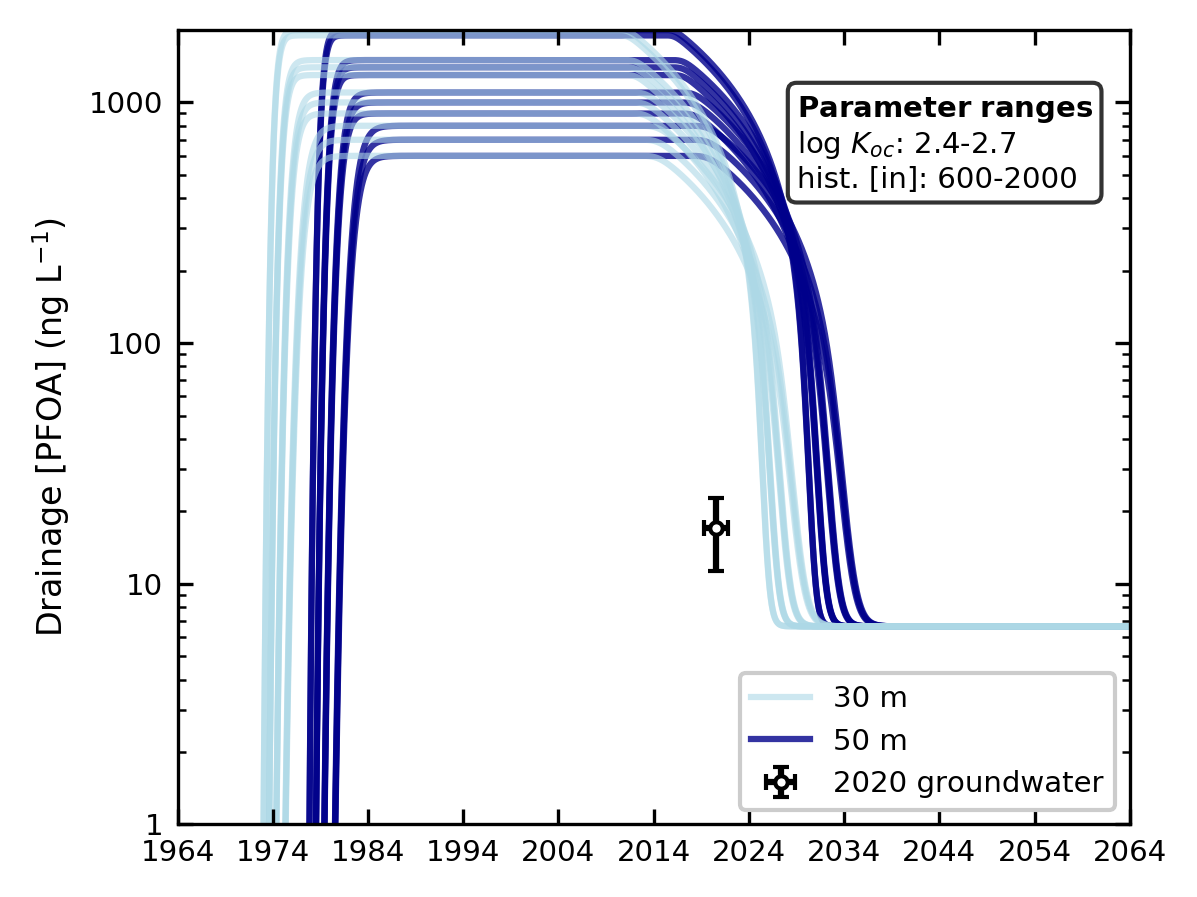

In [9]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,5201,1.)

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

#------------------------------------------
# linear transition
# plot best rms results
best_keys_30_5a = rms_drop5a[
#                     (rms_drop5a['con_in'] >= 20.) &
#                     (rms_drop5a['con_in'] <= 150.) &
                    (rms_drop5a['logKoc'].round(1) <= 2.7) &
                    (rms_drop5a['rms'] < 370)
                    ].index.values
best_keys_50_5a = rms_drop5a[
#                     (rms_drop5a['con_in'] == 20.) &
#                     ((rms_drop5a['logKoc'].round(1) == 2.6) |
                    (rms_drop5a['logKoc'].round(1) <= 2.7) &
                    (rms_drop5a['rms'] < 370)
                    ].index.values

for i,key in enumerate(best_keys_30_5a):
    thirty = thirty_df5a[key]
    if i == 0:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1, label='30 m')
    else:
        ax.plot(time,thirty,'-',alpha=.6,c='lightblue',zorder=1)
        
for i,key in enumerate(best_keys_50_5a):
    bottom = bottom_df5a[key]
    if i == 0:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1, label='50 m')
    else:
        ax.plot(time,bottom,'-',alpha=.8,c='darkblue',zorder=-1)

key = best_keys_30_5a[-1]
thirty = thirty_df5a[key]
vals = key.split('_')
second = best_keys_30_5a[0].split('_')
ax.annotate('$\mathbf{{Parameter}}$ $\mathbf{{ranges}}$\nlog $K_{oc}$: 2.4-2.7\nhist. [in]: 600-2000',
            (.65,.92),xycoords='axes fraction',bbox=bbox,va='top',ha='left')

#---------------------------
# make pretty

# ax.axvline(37*52,ls='-',c='r')
# ax.axvline(41*52,ls='--',c='r')

ax.set_xlim(0,100*52)
ax.set_xticks([x*52 for x in np.arange(0,110,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2074,10)]);

ax.errorbar([56.5*52],[gw_stats.loc['PFOA','mean']],
            yerr=[gw_stats.loc['PFOA','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)


ax.set_ylabel('Drainage [PFOA] (ng L$^{-1}$)')
# ax.set_ylim(-1,80)
ax.set_yscale('log')
ax.set_ylim(10**0,2000)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(which='both',direction='in',right=True,top=True)
# ax.tick_params(axis='x',labelrotation=90)
ax.legend(loc='lower right',framealpha=1)
# fig.patch.set_facecolor('w')
fig.tight_layout()
fig.savefig('./figs/pfoa_time_series_final.png')

## Profile

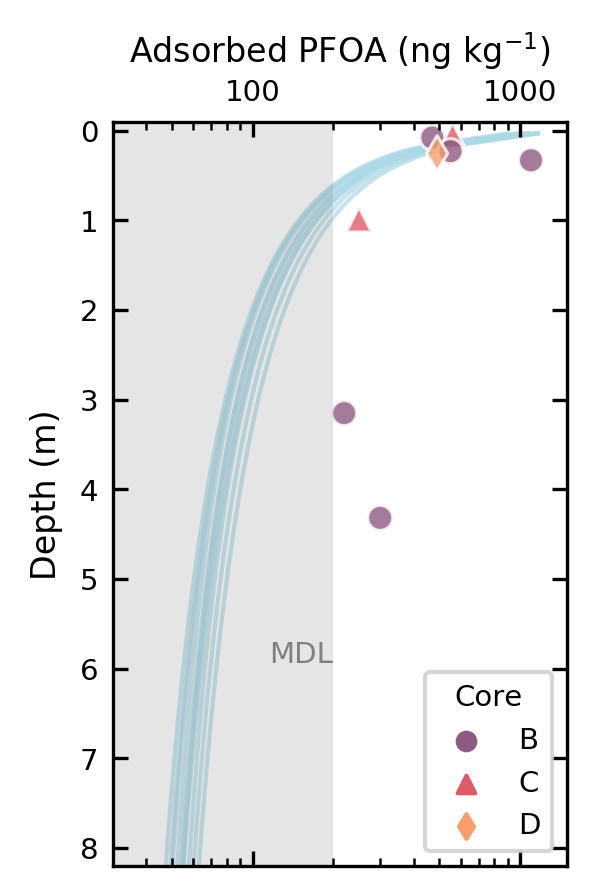

In [11]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOA',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D5a81','#DF5a69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)
low = .1
high = .9
number_of_lines = 1
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap('viridis_r')
colors = [ cmap(x) for x in cm_subsection ]

for key in best_keys_30_5a:
    ax.plot(ads_dict5a[key].loc[:,2601].values,ads_dict5a[key].loc[:,2601].index.values,'-',c='lightblue',alpha=.7,
           zorder=-1,lw=1)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='lower right',markerscale=.7, title='Core')


ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOA (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')

ax.annotate('', xy=(.95,.7), xycoords='axes fraction', fontsize=12,ha='right');

ax.set_xscale('log')
ax.set_xlim(30,1500)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(8.2,-.1)

ax.axvspan(1,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(200,6),color='gray',va='bottom',ha='right')
fig.tight_layout()
# fig.patch.set_facecolor('w')
fig.savefig('./figs/pfoa_profile_final.png')

## Faster flow scenarios

### Run example models

In [25]:
# 5. "daily" timestep, faster flowthrough
pfaa = 'PFOA'
con_mean = eff_stats.loc[pfaa,'mean']

koc = 10**2.5
kd = focs * koc
con_in = 1000

# add the false spacers to the daily timestep
line = list(np.linspace(con_in * V * 1000,con_mean * V * 1000,10*52))
down = []
for x in line:
    down+=[x]+[False]*6

# sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + ([con_mean * V * 1000]+[False]*6)*63*52
sol_mass_in = ([con_in * V * 1000]+[False]*6)*41*52 + down + ([con_mean * V * 1000]+[False]*6)*49*52
#                 + ([(con_in/2) * V * 1000]+[False]*6)*14*52\
                
ads5, sol5 = bucket_day(sol_mass_in,kd,soil_masses,pfaa)

thirty_df5 = sol5.iloc[370,:].values
bottom_df5 = sol5.iloc[-1,:].values

In [26]:
# 6. "daily" timestep, faster flowthrough
pfaa = 'PFOA'
con_mean = eff_stats.loc[pfaa,'mean']

koc = 10**2.4
kd = focs * koc
con_in = 1300

# add the false spacers to the daily timestep
line = list(np.linspace(con_in * V * 1000,con_mean * V * 1000,10*52))
down = []
for x in line:
    down+=[x]+[False]*6

# sol_mass_in = ([con_in * V * 1000]+[False]*6)*37*52 + ([con_mean * V * 1000]+[False]*6)*63*52
sol_mass_in = ([con_in * V * 1000]+[False]*6)*41*52 + down + ([con_mean * V * 1000]+[False]*6)*49*52
#                 + ([(con_in/2) * V * 1000]+[False]*6)*14*52\
                
ads6, sol6 = bucket_day(sol_mass_in,kd,soil_masses,pfaa)

thirty_df6 = sol5.iloc[370,:].values
bottom_df6 = sol5.iloc[-1,:].values

### time series

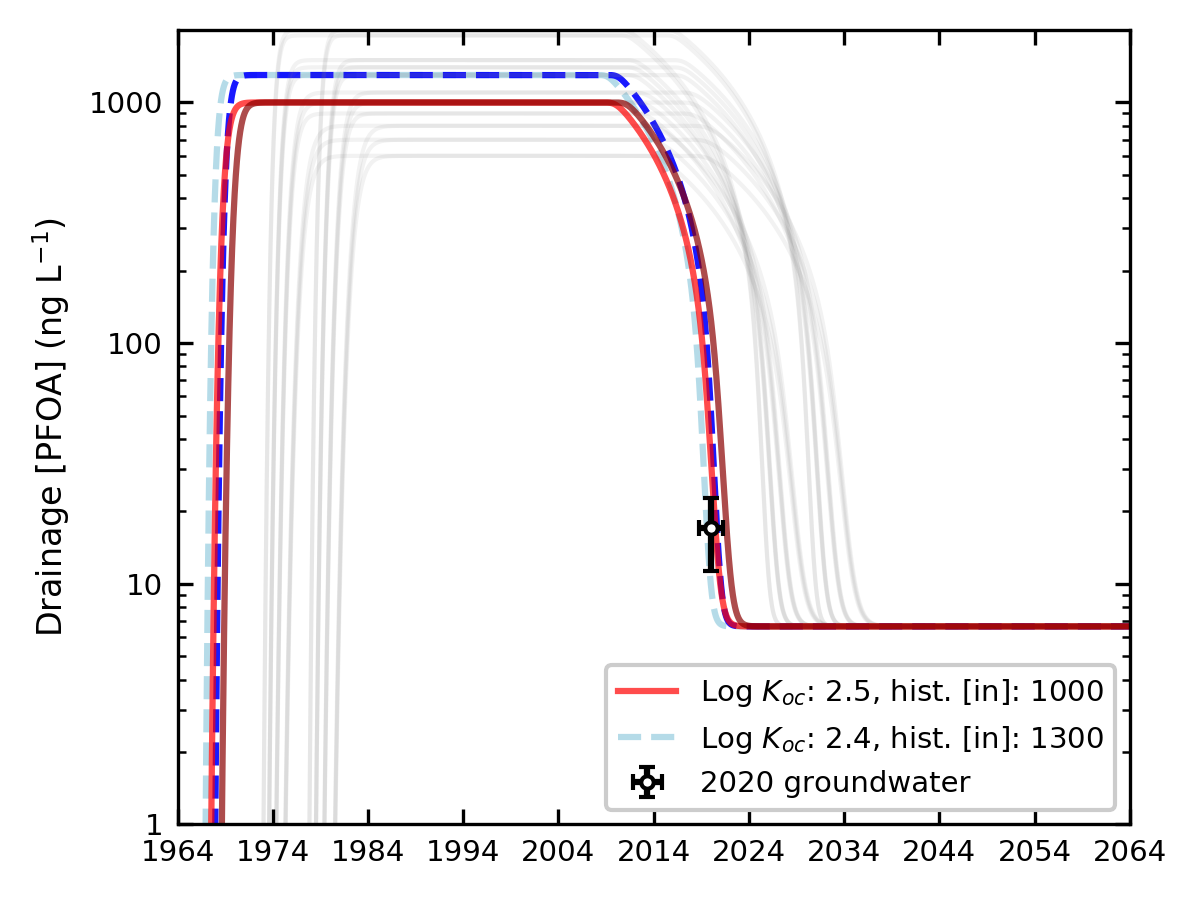

In [29]:
fig, ax = plt.subplots(figsize=(4,3),dpi=300)
time = np.arange(1,5201,1.)

bbox = dict(boxstyle="round", fc="w",lw='1',alpha=.8)

thi_day = sol5.loc[sol5.index[370],np.arange(7,sol5.columns[-1]+1,7)].values
bot_day = sol5.loc[sol5.index[-1],np.arange(1,sol5.columns[-1]+1,7)].values
ax.plot(time,thi_day,alpha=.7,zorder=1,c='red',ls='-',label='Log $K_{oc}$: 2.5, hist. [in]: 1000')
ax.plot(time,bot_day,alpha=.7,zorder=1,c='darkred',ls='-')

thi_day = sol6.loc[sol6.index[370],np.arange(7,sol6.columns[-1]+1,7)].values
bot_day = sol6.loc[sol6.index[-1],np.arange(1,sol6.columns[-1]+1,7)].values
ax.plot(time,thi_day,alpha=.9,zorder=-1,c='lightblue',ls='--',label='Log $K_{oc}$: 2.4, hist. [in]: 1300')
ax.plot(time,bot_day,alpha=.9,zorder=-1,c='blue',ls='--')

#------------------------------------------
# 2001 transition
# plot best rms results

for i,key in enumerate(best_keys_30_5a):
    thirty = thirty_df5a[key]
    ax.plot(time,thirty,'-',alpha=.1,lw=1,c='gray',zorder=-1)
        
for i,key in enumerate(best_keys_50_5a):
    bottom = bottom_df5a[key]
    ax.plot(time,bottom,'-',alpha=.1,lw=1,c='gray',zorder=-1)

#---------------------------
# make pretty

ax.set_xlim(0,100*52)
ax.set_xticks([x*52 for x in np.arange(0,110,10)]);
ax.set_xticklabels([x for x in np.arange(1964,2074,10)]);

ax.errorbar([56*52],[gw_stats.loc['PFOA','mean']],
            yerr=[gw_stats.loc['PFOA','std']],
            xerr=[1.25*52],
            fmt='o',label='2020 groundwater',c='k',zorder=2,ms=3,capsize=2)


ax.set_ylabel('Drainage [PFOA] (ng L$^{-1}$)')
# ax.set_ylim(-1,80)
ax.set_yscale('log')
ax.set_ylim(10**0,2000)
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.tick_params(which='both',direction='in',right=True,top=True)
# ax.tick_params(axis='x',labelrotation=90)
ax.legend(loc='best',framealpha=1,ncol=1)
fig.patch.set_facecolor('w')
fig.tight_layout()
fig.savefig('./figs/pfoa_time_series_scenarios.png')

### Profile

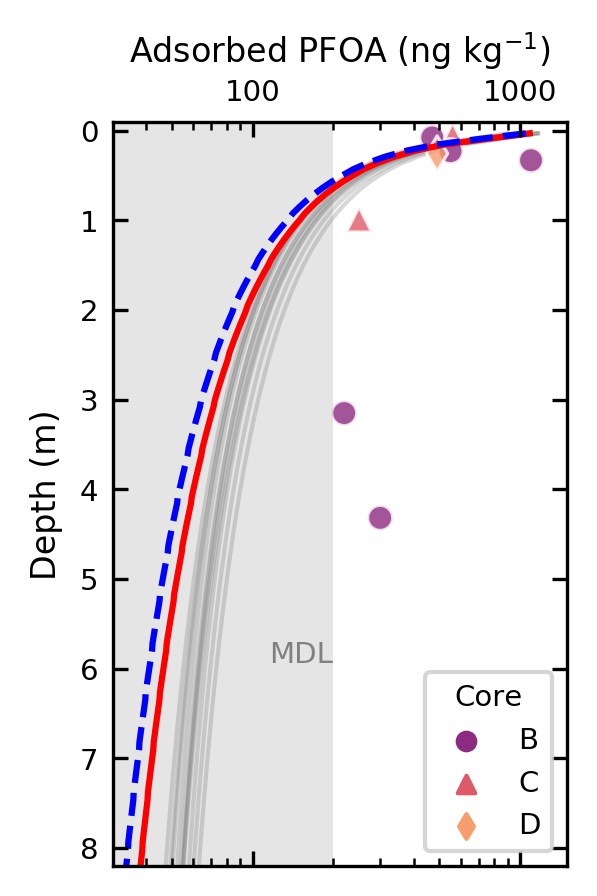

In [28]:
fig, ax = plt.subplots(1,1,figsize=(2,3),dpi=300,sharey=True)
sns.scatterplot(x='PFOA',y='depth_m',data=merged,hue='core',style='core',
                    palette=['#8D2A81','#DF5a69','#F89E6E'],hue_order=['B','C','D'],style_order=['B','C','D'],
                    markers=['o','^','d'],alpha=.8,
                    ax=ax,zorder=1)

for key in best_keys_50_5a:
    ax.plot(ads_dict5a[key].loc[:,2601].values,ads_dict5a[key].loc[:,2601].index.values,
            alpha=.3,c='gray',lw=1,zorder=-1)
    
ax.plot(ads5.loc[:,2601*7].values,ads5.loc[:,2601*7].index.values,'-',alpha=1,c='r',zorder=1)
ax.plot(ads6.loc[:,2601*7].values,ads6.loc[:,2601*7].index.values,'--',alpha=1,c='b',zorder=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:], loc='lower right',markerscale=.7, title='Core')

ax.set_ylabel('Depth (m)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Adsorbed PFOA (ng kg$^{-1}$)')


ax.tick_params(which='both',direction='in',bottom=True,right=True,top=True,labeltop=True,labelbottom=False)
ax.xaxis.set_label_position('top')


ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim(30,1500)
ax.set_ylim(8.2,-.1)

ax.axvspan(.01,200,lw=0,color='gray',alpha=.2)
ax.annotate('MDL',xy=(.2*1000,6),color='gray',va='bottom',ha='right')
fig.tight_layout()
fig.patch.set_facecolor('w')
fig.savefig('./figs/pfoa_profile_scenarios.png')